# Inhomogeneous Gaussian target with diagonal covariance matrix.

In [1]:
import numpy as np
import jax
import matplotlib.pyplot as plt

In [2]:
# set up true mean and covariance matrix

mu = np.ones(100)

sd = np.linspace(0.01, 1, 100)

cov = np.zeros((100, 100))

for i in range(100):
    cov[i, i] = sd[i]**2

In [3]:
# define necessary functions for implementation

# multivariate gaussian density
def multivariate_gaussian(x, mu, cov):
    part1 = 1 / ( ((2* np.pi)**(len(mu)/2)) * (np.linalg.det(cov)**(1/2)) )
    part2 = (-1/2) * ((x-mu).dot(np.linalg.inv(cov))).dot((x-mu))
    return float(part1 * np.exp(part2))

# log of gaussian density
def log_gauss(x, mu, cov):
    scale = np.linalg.cholesky(cov)
    v = jax.lax.linalg.triangular_solve(
      scale, x - mu, left_side=True, lower=True
    )
    return -0.5 * np.sum(v * v)


# gradient of log gaussian density
def grad_log_gauss(x,mu,cov):
    scale = np.linalg.cholesky(cov)
    v = jax.lax.linalg.triangular_solve(
      scale, x - mu, left_side=True, lower=True
    )
    return - jax.lax.linalg.triangular_solve(
      np.transpose(scale), v, left_side=True, lower=False
    )


# Fisher MALA algorithm

## step 1. simple MALA for initialisation

In [4]:
# initialisation
lam = 10 # default value

average_acc_rate = 0.574 # adapt step size toward achieving this acceptance rate.
rho = 0.015


rng = np.random.default_rng(42)
# number of iteration
N = 500

# initialise step size which is sigma^2 in paper
# 0.002 seems reasonable from trials
step_size = 0.0005

acceptance_rate_collection =  []
#initial sample obtained by drawing from standard normal as stated

x = rng.normal(0,1,100) # initial value

# 500 iterations.
for _ in range(N):

    # obtain x' through the formula
    y = x + (step_size/2) * grad_log_gauss(x, mu, cov) + np.sqrt(step_size) * rng.normal(0,1,len(mu))

    # Metropolis
    u = rng.uniform(0, 1)

    log_acc_rate = log_gauss(y, mu, cov) + log_gauss(x, y+step_size/2 *grad_log_gauss(y,mu,cov), step_size * np.identity(len(mu))) - \
            (log_gauss(x, mu, cov) + log_gauss(y, x + step_size/2 *grad_log_gauss(x,mu,cov) , step_size * np.identity(len(mu))))
    # if u < acceptance rate, we accept the sample
    if np.log(u) < log_acc_rate:
        x = y

    else:
        x = x

    # adapt the step size toward 0.574
    acc_rate = min(1, np.exp(log_acc_rate))
    acceptance_rate_collection.append(acc_rate)
    # Step size adaptation towards the optimal acceptance rate
    step_size = step_size * (1+ rho * (acc_rate - average_acc_rate))


print(f'Final sample in first 500 iterations:{x}')
print(f'Final adapted step size in first 500 iterations:{step_size}')

C:\Users\kaixi\AppData\Local\Temp\ipykernel_9452\1169906597.py:40: RuntimeWarning: overflow encountered in exp
  acc_rate = min(1, np.exp(log_acc_rate))


Final sample in first 500 iterations:[ 1.01532412e+00  1.02629590e+00  9.91542935e-01  1.00368643e+00
  9.93484735e-01  1.00752366e+00  9.88839030e-01  8.03657889e-01
  1.09833574e+00  9.91425216e-01  8.27687562e-01  7.87631094e-01
  9.31384802e-01  1.21061981e+00  1.08666015e+00  6.80983067e-01
  9.58259463e-01  4.98613834e-01  8.63009989e-01  5.44734538e-01
  7.30338454e-01  2.98322856e-01  9.17759359e-01  3.24927628e-01
  2.65824087e-02 -1.95114627e-01  4.00320917e-01  9.71109390e-01
  8.27785254e-01  4.80648279e-01  1.85687518e+00  2.79738039e-01
 -1.65776491e-01 -2.57466018e-01  4.59822595e-01  1.32130480e+00
  2.60543048e-01 -6.14412308e-01 -2.08615616e-01  9.46755409e-01
  8.27258468e-01  4.27958161e-01 -8.34352747e-02  8.85881186e-01
  4.67933983e-01 -1.23683944e-01  1.19693160e+00  5.70391655e-01
  7.49936342e-01  4.45340216e-01  5.43685555e-01  5.50146222e-01
 -1.46462536e+00  3.65479201e-01 -8.17993283e-02 -2.01523572e-01
 -6.48209304e-02  1.39276743e+00 -7.23217130e-01  8.9

The overflow warning is dealt with by function min(1, acc_rate).

In [5]:
# This can be used as a metric to choose a good initial step size
print(f'average acceptance rate:{np.mean(acceptance_rate_collection)}')

average acceptance rate:0.5318157465408714


## step 2. Fisher MALA

In [6]:
# initialisation
N = int(1.95 * 10**4)

# step_size_R is sigma_R^2 in the paper
step_size_R = step_size # adapted step size from final iteration above. place holder for normalised step size.
R = np.identity(len(mu)) # initialise the square root matrix with identity matrix.

# define function h as stated in proposition 1.
def h(z,v, step_size, R, mu, cov):
    return (1/2) * (z- v- (step_size/4)* (R @ (R.T)).dot(grad_log_gauss(v, mu, cov))).dot(grad_log_gauss(v, mu, cov))

In [7]:
acc_rate_collection = []

# collecting normalised preconditioning matrix of fisher algorithm for Frobenius norm calculation
normalised_preconditioner_fisher = []

for n in range(1,N+1):

    # append normalised matrix to a list for plotting Frobenius norm later
    normalised_preconditioner_fisher.append(R@R.T/(1/len(mu) * np.trace(R@R.T)))

    y = x + step_size_R/2 * R.dot(R.T.dot(grad_log_gauss(x, mu, cov))) + np.sqrt(step_size_R) * R.dot(rng.normal(0,1,len(mu)))

    # using proposition 1 to compute acceptance rate, mistake for using step_size_R as step size
    acc_rate = min(1, np.exp(log_gauss(y, mu, cov) + h(x, y, step_size_R, R, mu, cov) -\
                     log_gauss(x, mu, cov) - h(y, x, step_size_R, R, mu, cov)))

    # collect acceptance rate
    acc_rate_collection.append(acc_rate)

    # compute adaptation signal for updating R later
    s = np.sqrt(acc_rate) * (grad_log_gauss(y, mu, cov) - grad_log_gauss(x, mu, cov))

    # use s to adapt R based on proposition 4
    if n == 1:
        r1 = 1/(1+ np.sqrt(lam/(lam + np.dot(s,s))))
        R = (1/ np.sqrt(lam))* (R - r1 * (np.outer(s,s)/(lam + np.dot(s,s))))
        # print(f'1st square root matrix:{R}')
    else:
        phi = (R.T).dot(s)
        r = 1/(1+ np.sqrt(1/ (1+np.dot(phi,phi))))
        R = R - r * np.outer((R.dot(phi)),phi)/(1+ np.dot(phi,phi))

    # adapt step size using the formula. mistake here in 1st version
    # let the step size adapt as before in Simple MALA
    step_size = step_size * (1+ rho * (acc_rate - average_acc_rate))

    # normalise the step size for the proposal in next iteration.
    step_size_R = step_size / ((1/len(mu)) * np.trace(R @ (R.T)))

    # Metropolis step - accept/ reject y  with probability acc_rate
    u = rng.uniform(0, 1)

    if u < acc_rate:
        x = y

    else:
        x = x

In [8]:
# print(f'Final sample after burn-in iterations:{x}')
print(f'Final step size after burn-in iterations:{step_size}')
print(f'Final adapted normalised step size after burn-in iterations:{step_size_R}')
print(f'Average acceptance rate:{np.mean(acc_rate_collection)}')
print(f'Adapted square root matrix:\n {R}')

Final step size after burn-in iterations:0.20181699530318226
Final adapted normalised step size after burn-in iterations:4122.2951069405835
Average acceptance rate:0.5965225939748283
Adapted square root matrix:
 [[ 9.94099898e-05  2.43468218e-05  1.20679881e-05 ... -1.16698785e-07
   4.23181618e-07 -6.45036177e-07]
 [-7.24327716e-05  2.04187414e-04 -1.53736301e-05 ... -1.16155284e-06
  -3.00073642e-06 -1.13574935e-06]
 [-5.40917147e-05  2.15046284e-05  3.30640723e-04 ...  7.64659659e-07
  -2.99739795e-06  6.16677231e-06]
 ...
 [-4.13620648e-05  6.15027868e-05  8.75644038e-05 ...  1.17998006e-02
  -6.44426734e-06 -1.48079814e-04]
 [-1.74273115e-04  1.60201383e-04  7.64576126e-05 ... -9.37108717e-05
   1.18684789e-02  9.47004564e-05]
 [ 5.43412454e-05  1.90178595e-04 -2.13375617e-04 ...  8.48085506e-05
  -1.36599602e-04  1.19909806e-02]]


Display the matrices for comparison between the final normalised Fisher preconditioner and the true normalised covariance matrix.

In [9]:
final_normalised_fisher_preconditioner = (R@R.T)/(1/len(mu) * np.trace(R@R.T))
print(f'normalised preconditioning matrix:{final_normalised_fisher_preconditioner}')

normalised preconditioning matrix:[[ 2.97291859e-04 -7.53404298e-06  2.90091119e-06 ... -3.35858805e-05
  -1.36490499e-04  5.31196775e-05]
 [-7.53404298e-06  1.20007943e-03  2.42970717e-06 ...  1.29919433e-04
   5.30488931e-05  5.19850197e-04]
 [ 2.90091119e-06  2.42970717e-06  2.66839207e-03 ...  4.84603613e-04
  -7.69789045e-05 -1.97354063e-05]
 ...
 [-3.35858805e-05  1.29919433e-04  4.84603613e-04 ...  2.86083149e+00
  -2.12791763e-02 -1.47898946e-02]
 [-1.36490499e-04  5.30488931e-05 -7.69789045e-05 ... -2.12791763e-02
   2.89381560e+00 -9.73360583e-03]
 [ 5.31196775e-05  5.19850197e-04 -1.97354063e-05 ... -1.47898946e-02
  -9.73360583e-03  2.95244581e+00]]


In [10]:
print(f'normalised true covariance matrix:{cov/(1/len(mu) * np.trace(cov))}')

normalised true covariance matrix:[[2.95551943e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.18220777e-03 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.65996749e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.83848086e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  2.89670460e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 2.95551943e+00]]


## Sampling phase of FisherMALA

In [12]:
# initialisation
N = int(2 * 10**4)
# sample collection each row for each dimension, column for number of samples.
Fisher_MALA_samples = np.zeros((100, N+1))
Fisher_MALA_samples[:, 0] = np.array(rng.normal(0,1,100))
for n in range(1, N+1):
    y = Fisher_MALA_samples[:,n-1] + step_size_R/2 * R.dot(R.T.dot(grad_log_gauss(Fisher_MALA_samples[:,n-1], mu, cov))) + np.sqrt(step_size_R) * R.dot(rng.normal(0,1,len(mu)))

    # using proposition 1 to compute acceptance rate, mistake for using step_size_R as step size
    acc_rate = min(1, np.exp(log_gauss(y, mu, cov) + h(Fisher_MALA_samples[:, n-1], y, step_size_R, R, mu, cov) -\
                     log_gauss(Fisher_MALA_samples[:, n-1], mu, cov) - h(y, Fisher_MALA_samples[:, n-1], step_size_R, R, mu, cov)))


    # Metropolis step - accept/ reject y  with probability acc_rate
    u = rng.uniform(0, 1)

    if u < acc_rate:
        Fisher_MALA_samples[:,n] = y
    else:
        Fisher_MALA_samples[:,n]  = Fisher_MALA_samples[:,n-1]

C:\Users\kaixi\AppData\Local\Temp\ipykernel_9452\2346826552.py:10: RuntimeWarning: overflow encountered in exp
  acc_rate = min(1, np.exp(log_gauss(y, mu, cov) + h(Fisher_MALA_samples[:, n-1], y, step_size_R, R, mu, cov) -\


# AdaMALA

## step1. 500 simple MALA initialisation to adapt step size.

In [13]:
rng = np.random.default_rng(36)
# number of iteration
N = 500
# initialise step size which is sigma^2 in paper
# 0.1 seems reasonable from trials
step_size = 0.01
acceptance_rate_collection =  []

#initial sample obtained by drawing from standard normal as stated
x = rng.normal(0,1,100)
# 500 iterations.
for _ in range(N):
    
    # obtain x' through the formula
    y = x + (step_size/2) * grad_log_gauss(x, mu, cov) + np.sqrt(step_size) * rng.normal(0,1,len(mu))

    # Metropolis
    u = rng.uniform(0, 1)
    log_acc_rate = log_gauss(y, mu, cov) + log_gauss(x, y+step_size/2 *grad_log_gauss(y,mu,cov), step_size * np.identity(len(mu))) - \
            (log_gauss(x, mu, cov) + log_gauss(y, x + step_size/2 *grad_log_gauss(x,mu,cov) , step_size * np.identity(len(mu))))

    # if u < acceptance rate, we accept the sample
    if np.log(u) < log_acc_rate:
        x = y
    else:
        x = x

    # adapt the step size toward 0.574
    acc_rate = min(1, np.exp(log_acc_rate))
    acceptance_rate_collection.append(acc_rate)
    # Step size adaptation towards the optimal acceptance rate
    step_size = step_size * (1+ rho * (acc_rate - average_acc_rate))
print(f'Final adapted step size in first 500 iterations:{step_size}')

C:\Users\kaixi\AppData\Local\Temp\ipykernel_9452\2058486669.py:29: RuntimeWarning: overflow encountered in exp
  acc_rate = min(1, np.exp(log_acc_rate))


Final adapted step size in first 500 iterations:0.0003906926401446386


## Another 500 iterations to adapt covariance matrix.

In [14]:
# initialisation the mean with final sample from step 1.
mean = x
# number of iteration
N = 500
normalised_preconditioner_ada = []
acc_rate_collection = []
for n in range(2, N+2):
    # obtain x' through the formula
    y = x + (step_size/2) * grad_log_gauss(x, mu, cov) + np.sqrt(step_size) * rng.normal(0,1,len(mu))

    # Metropolis
    u = rng.uniform(0, 1)
    log_acc_rate = log_gauss(y, mu, cov) + log_gauss(x, y+step_size/2 *grad_log_gauss(y,mu,cov), step_size * np.identity(len(mu))) - \
            (log_gauss(x, mu, cov) + log_gauss(y, x + step_size/2 *grad_log_gauss(x,mu,cov) , step_size * np.identity(len(mu))))
    # if u < acceptance rate, we accept the sample
    if np.log(u) < log_acc_rate:
        x = y

    else:
        x = x
    # Adapt empirical covariance
    if n == 2:
        Sigma = (1./n)* np.outer((x-mean),(x-mean)) + lam * np.identity(len(mu))

    else:
        Sigma = ((n-2.)/(n-1.)) * Sigma + (1./n) * np.outer((x-mean), (x-mean))
    # append normalised matrix for plot of Frobenius norm
    normalised_preconditioner_ada.append(Sigma/(1/len(mu) * np.trace(Sigma)))
    # adapt the empirical mean
    mean = mean + (1./n) * (x - mean)
    # adapt the step size toward 0.574
    acc_rate = min(1, np.exp(log_acc_rate))
    acc_rate_collection.append(acc_rate)
    
    # Step size adaptation towards the optimal acceptance rate
    step_size = step_size * (1+ rho * (acc_rate - average_acc_rate))

print(f'Final empirical covariance after 500 iterations:{Sigma}')
print(f'Final empirical mean after 500 iterations:{mean}')
print(f'Final adapted step size after first 1000 iterations:{step_size}')
print(f'Average acceptance rate:{np.mean(acc_rate_collection)}')

C:\Users\kaixi\AppData\Local\Temp\ipykernel_9452\2342004289.py:32: RuntimeWarning: overflow encountered in exp
  acc_rate = min(1, np.exp(log_acc_rate))


Final empirical covariance after 500 iterations:[[ 3.19371005e-02 -3.27010402e-05  1.16148782e-04 ...  8.27626543e-04
  -2.02105021e-04 -2.81884682e-04]
 [-3.27010402e-05  2.04572151e-02 -1.78984876e-05 ... -3.34826554e-04
   6.79741673e-05 -1.76054330e-04]
 [ 1.16148782e-04 -1.78984876e-05  2.07930134e-02 ... -6.28160786e-04
  -1.30119864e-04 -4.32916391e-04]
 ...
 [ 8.27626543e-04 -3.34826554e-04 -6.28160786e-04 ...  3.09157530e-02
  -2.42276042e-03  2.97226194e-03]
 [-2.02105021e-04  6.79741673e-05 -1.30119864e-04 ... -2.42276042e-03
   2.41426682e-02  7.19603939e-05]
 [-2.81884682e-04 -1.76054330e-04 -4.32916391e-04 ...  2.97226194e-03
   7.19603939e-05  2.53586859e-02]]
Final empirical mean after 500 iterations:[ 1.0036122   1.0010386   0.9975366   0.99693817  1.0066006   1.0139279
  0.9982502   1.0389168   1.0109192   1.0421875   0.8419657   0.99010295
  0.6866026   0.7585246   1.0725433   0.86213225  0.50854415  0.35298267
  0.5984695   0.66299933  0.34945172  0.7072602   0.7898

## For remaining burn-in iterations adapt covariance using proposal in equation (7) in the paper.

In [15]:
# initialisation
N = int(1.9 * 10**4)
step_size_R = step_size / ((1/len(mu)) * np.trace(Sigma))
acc_rate_collection = []
mean = mean # final mean value from above
Sigma = Sigma # final covariance from above.

# for n in range(3,N+3):
for n in range(502,N+502):
    R = np.linalg.cholesky(Sigma)
    
    y = x + (step_size_R/2) * Sigma.dot(grad_log_gauss(x, mu, cov)) + np.sqrt(step_size_R) * R.dot(rng.normal(0,1,len(mu)))

    acc_rate = min(1, np.exp(log_gauss(y, mu, cov) + h(x, y, step_size_R, R, mu, cov) -\
                     log_gauss(x, mu, cov) - h(y, x, step_size_R, R, mu, cov)))
    
    # collect acceptance rate
    acc_rate_collection.append(acc_rate)
    
    # Metropolis step - accept/ reject y  with probability acc_rate
    u = rng.uniform(0, 1)
    if u < acc_rate:
        x = y
    else:
        x = x
        
    Sigma = ((n-2.)/(n-1.)) * Sigma + (1./n) * np.outer((x-mean), (x-mean))
    mean = mean + (1./n) * (x - mean)

    # appending the normalised preconditioner for later plot of Frobenius norm
    normalised_preconditioner_ada.append(Sigma/(1/len(mu) * np.trace(Sigma)))

    # adapt step size
    step_size = step_size * (1+ rho * (acc_rate - average_acc_rate))

    # normalise the step size for the proposal in next iteration.
    step_size_R = step_size / ((1./len(mu)) * np.trace(Sigma))

In [16]:
print(f'Final empirical covariance after burn-in iterations:\n{Sigma}')
print(f'Final empirical mean after burn-in iterations:\n{mean}')
print(f'Average acceptance rate:{np.mean(acc_rate_collection)}')

Final empirical covariance after burn-in iterations:
[[ 9.17464861e-04  3.90304887e-06  1.14370830e-06 ... -1.36383913e-04
   3.70277918e-05 -9.46447600e-05]
 [ 3.90304887e-06  9.16415830e-04  8.98418970e-06 ...  2.78005285e-06
  -7.21071776e-04  5.22699773e-05]
 [ 1.14370830e-06  8.98418970e-06  1.39335370e-03 ...  2.80514901e-04
   6.54883201e-04  6.73767040e-05]
 ...
 [-1.36383913e-04  2.78005285e-06  2.80514901e-04 ...  2.64409656e-01
   1.41351832e-01  3.30098300e-02]
 [ 3.70277918e-05 -7.21071776e-04  6.54883201e-04 ...  1.41351832e-01
   7.70429426e-01  3.44295787e-02]
 [-9.46447600e-05  5.22699773e-05  6.73767040e-05 ...  3.30098300e-02
   3.44295787e-02  1.92858952e-01]]
Final empirical mean after burn-in iterations:
[ 9.9988633e-01  9.9949253e-01  1.0001273e+00  1.0016514e+00
  1.0002974e+00  1.0060980e+00  9.9561298e-01  9.9658233e-01
  9.9511468e-01  9.8273289e-01  9.8681188e-01  1.0121651e+00
  1.0055296e+00  1.0112900e+00  1.0187215e+00  9.8569626e-01
  1.0152210e+00  1.0

In [17]:
final_normalised_ada_preconditioner= Sigma/(np.trace(Sigma)/len(mu))
print(f'normalised adaMALA precondioner:{final_normalised_ada_preconditioner}')

normalised adaMALA precondioner:[[ 5.67464183e-03  2.41408749e-05  7.07398750e-06 ... -8.43552586e-04
   2.29021803e-04 -5.85390392e-04]
 [ 2.41408749e-05  5.66815344e-03  5.55684048e-05 ...  1.71949956e-05
  -4.45992456e-03  3.23296741e-04]
 [ 7.07398750e-06  5.55684048e-05  8.61807744e-03 ...  1.73502186e-03
   4.05053945e-03  4.16733849e-04]
 ...
 [-8.43552586e-04  1.71949956e-05  1.73502186e-03 ...  1.63540879e+00
   8.74279829e-01  2.04170176e-01]
 [ 2.29021803e-04 -4.45992456e-03  4.05053945e-03 ...  8.74279829e-01
   4.76520817e+00  2.12951510e-01]
 [-5.85390392e-04  3.23296741e-04  4.16733849e-04 ...  2.04170176e-01
   2.12951510e-01  1.19285820e+00]]


## Sampling phase of AdaMALA

In [18]:
# initialisation
N = int(2 * 10**4)
# sample collection each row for each dimension, column for number of samples.
AdaMALA_samples = np.zeros((100, N+1))
AdaMALA_samples[:, 0] = np.array(rng.normal(0,1,100))
for n in range(1, N+1):
    R = np.linalg.cholesky(Sigma)
    y = AdaMALA_samples[:,n-1] + (step_size_R/2) * Sigma.dot(grad_log_gauss(AdaMALA_samples[:,n-1], mu, cov)) + np.sqrt(step_size_R) * R.dot(rng.normal(0,1,len(mu)))
    # using proposition 1 to compute acceptance rate, mistake for using step_size_R as step size
    acc_rate = min(1, np.exp(log_gauss(y, mu, cov) + h(AdaMALA_samples[:, n-1], y, step_size_R, R, mu, cov) -\
                     log_gauss(AdaMALA_samples[:, n-1], mu, cov) - h(y, AdaMALA_samples[:, n-1], step_size_R, R, mu, cov)))

    # Metropolis step - accept/ reject y  with probability acc_rate
    u = rng.uniform(0, 1)
    if u < acc_rate:
        AdaMALA_samples[:,n] = y
    else:
        AdaMALA_samples[:,n]  = AdaMALA_samples[:,n-1]

C:\Users\kaixi\AppData\Local\Temp\ipykernel_9452\2299928318.py:10: RuntimeWarning: overflow encountered in exp
  acc_rate = min(1, np.exp(log_gauss(y, mu, cov) + h(AdaMALA_samples[:, n-1], y, step_size_R, R, mu, cov) -\


# Frobenius norm

In [19]:
normalised_cov = cov/(1/len(mu) * np.trace(cov))
# compute the difference between the true covariance matrix and each of collected adapting covariance matrix
difference_ada = normalised_preconditioner_ada - normalised_cov
difference_fisher = normalised_preconditioner_fisher - normalised_cov
# empty list to store the Frobenius norm
fro_norm_ada = []
fro_norm_fisher = []
# compute the Frobenius norm of the deviation from the true covariance matrix. 
for i in difference_ada:
    fro_norm_ada.append(np.linalg.norm(i))
for j in difference_fisher:
    fro_norm_fisher.append(np.linalg.norm(j))

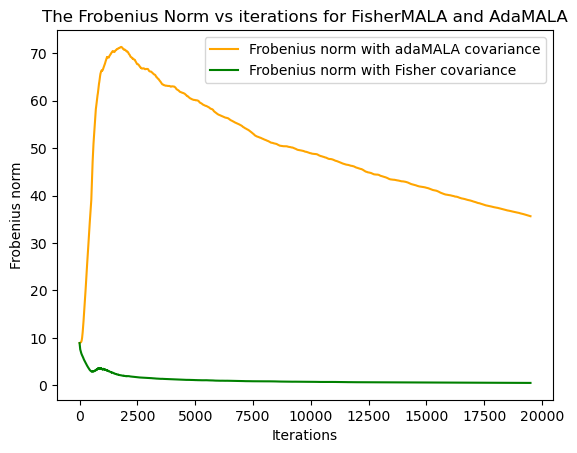

In [20]:
iterations = np.arange(0, int(1.95 * 10**4))
plt.plot(iterations, fro_norm_ada, label = 'Frobenius norm with adaMALA covariance', color = 'orange')
plt.plot(iterations, fro_norm_fisher, label = 'Frobenius norm with Fisher covariance', color = 'green')
plt.ylabel('Frobenius norm')
plt.xlabel('Iterations')
plt.title("The Frobenius Norm vs iterations for FisherMALA and AdaMALA")
plt.legend()
plt.show()

Compare to the plot in the paper.

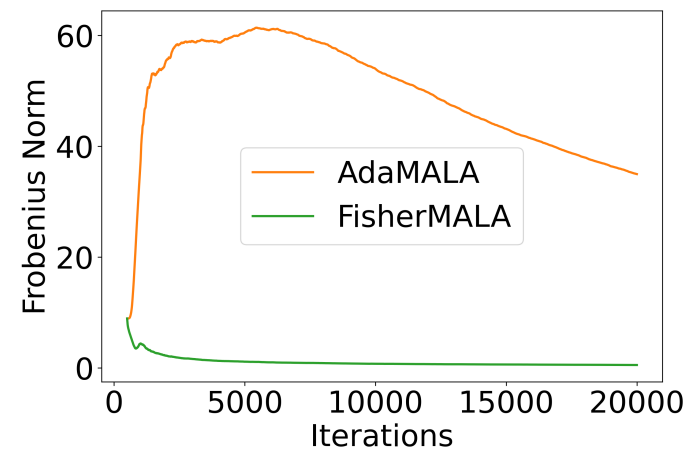

In [21]:
print(f'FisherMALA Frobenius norm converges to:{fro_norm_fisher[-1]}')
print(f'AdaMALA Frobenius norm after 19500 iterations:{fro_norm_ada[-1]}')

FisherMALA Frobenius norm converges to:0.4969814963523088
AdaMALA Frobenius norm after 19500 iterations:35.64789302423139


# Figure 2b Now plot the estimated standard deviation from the optimised precondtioning matrix from adaMALA and FisherMALA.

I extract the diagonal element of the final estimated normalised covariance matrix and square root them to obtain the standard deviation for each dimension.

In [22]:
# Extracting the diagonal elements of matrices
var_ada = np.diag(final_normalised_ada_preconditioner)
var_fisher = np.diag(final_normalised_fisher_preconditioner)

# standard deviation from AdaMALA estimation
sd_ada = np.sqrt(var_ada)
# standard deviation from FisherMALA estimation
sd_fisher = np.sqrt(var_fisher)

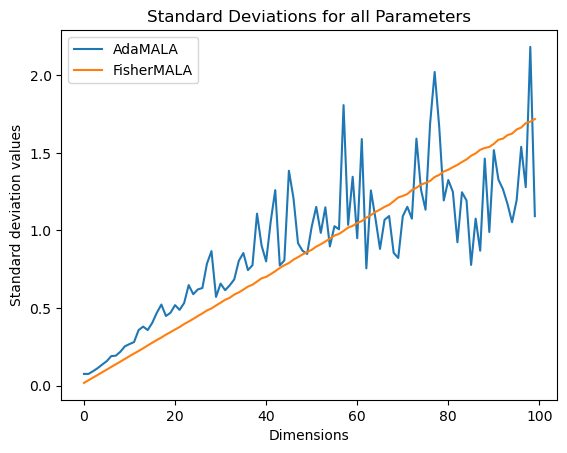

In [23]:
dimensions = np.linspace(0,99,100)
plt.plot(dimensions, sd_ada, label= 'AdaMALA')
plt.plot(dimensions, sd_fisher, label = 'FisherMALA')
plt.title('Standard Deviations for all Parameters')
plt.ylabel('Standard deviation values')
plt.xlabel('Dimensions')
plt.legend()

Plot from the paper.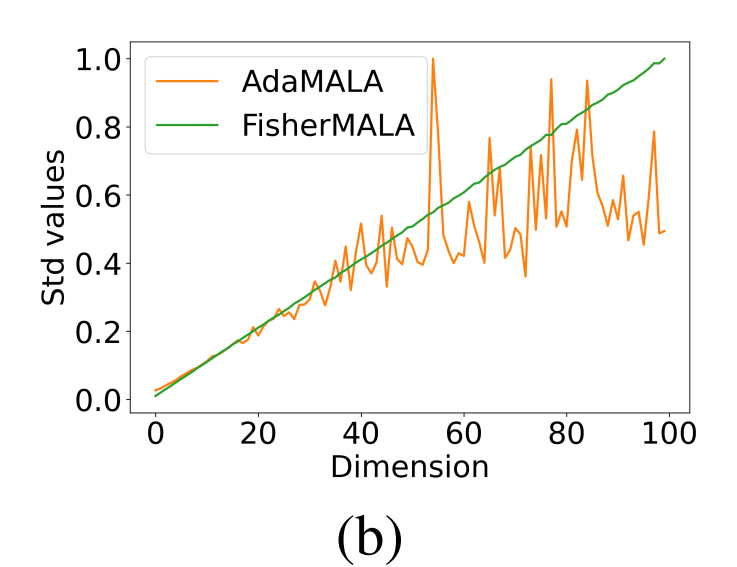